# Описание проекта

Определяем в какой местности следует бурить скважину.

Имеется информация о пробах нефти из 1 регионов в каждом из которых по 10 000 месторождений. Оценка месторождения производилась по качеству нефти и объёму её запасов. 

В работе построины модели машинного обучения для определения региона с наибольшей прибылью. Анализ возможной прибыли и рисков проводился техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка и подготовка данных

In [2]:
first_region=pd.read_csv('datasets\geo_data_0.csv')
second_region=pd.read_csv('datasets\geo_data_1.csv')
third_region=pd.read_csv('datasets\geo_data_2.csv')

In [3]:
first_region.sample(5)

,id,f0,f1,f2,product
45850,jSyrJ,0.122444,0.075792,6.627095,99.953256
47984,q5hp1,1.751408,-0.229391,4.749133,96.928773
35738,bsdqt,0.740752,0.561043,-0.356591,28.215686
70427,gSH0I,-0.947769,0.686815,-0.391665,13.922426
78922,tc8eA,0.263122,-0.109926,8.514659,182.013795


In [4]:
second_region.sample(5)

,id,f0,f1,f2,product
47629,YoXwc,14.271551,2.245855,5.003822,134.766305
5837,3prLw,1.803381,-4.516483,2.998402,80.859783
59289,F1K9F,-9.241251,-10.016626,-0.000070,3.179103
31947,qPUIz,6.313942,0.821685,0.011552,0.000000
48384,M17f4,-6.725764,-8.906824,5.000820,137.945408


In [5]:
third_region.sample(5)

,id,f0,f1,f2,product
19552,s80om,2.820839,-0.897049,6.412878,139.792783
72178,MDAZv,-0.205096,2.549717,3.060254,153.828880
86620,1Rpm2,-0.078380,3.227364,6.434059,150.548924
52551,IFjh8,-1.482637,1.214254,-0.482627,65.972930
43567,61lMx,0.914178,-1.033731,4.992585,132.123560


In [6]:
#Проверим id на уникальность, может есть скважины с коллизией в названии
regions=[list(first_region.id), list(second_region.id), list(third_region.id)]
#Для первого проверяем 2 и 3 регионы
def find_collision():
    for name in regions[0]:
        #Сперва ищем во второй 
        if name in regions[1]:
            print('Есть коллизия с именем (1<->2)',name)
        if name in regions[2]:
            print('Есть коллизия с именем (1<->3)',name)
    #Для второго только 3
    for name in regions[1]:
        #Сперва ищем во второй 
        if name in regions[2]:
            print('Есть коллизия с именем (2<->3)',name)

In [7]:
%%time
#Это лучше не запускать
#find_collision()

Wall time: 0 ns


In [8]:
first_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
second_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
third_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
pd.merge(pd.merge(first_region.describe(),second_region.describe(), 
         left_index=True, right_index=True,
        suffixes=('', '_second')), third_region.describe(),
         left_index=True, right_index=True,
        suffixes=('', '_third')).T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347
f0_second,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1_second,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2_second,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product_second,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408
f0_third,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1_third,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801


In [12]:
#Дропнем столбец id для всех регионов и объединим их
first_region.drop('id',axis=1, inplace=True, errors='ignore')
second_region.drop('id',axis=1, inplace=True, errors='ignore')
third_region.drop('id',axis=1, inplace=True, errors='ignore')

In [13]:
second_region

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...
99995,9.535637,-6.878139,1.998296,53.906522
99996,-10.160631,-12.558096,5.005581,137.945408
99997,-7.378891,-3.084104,4.998651,137.945408
99998,0.665714,-6.152593,1.000146,30.132364


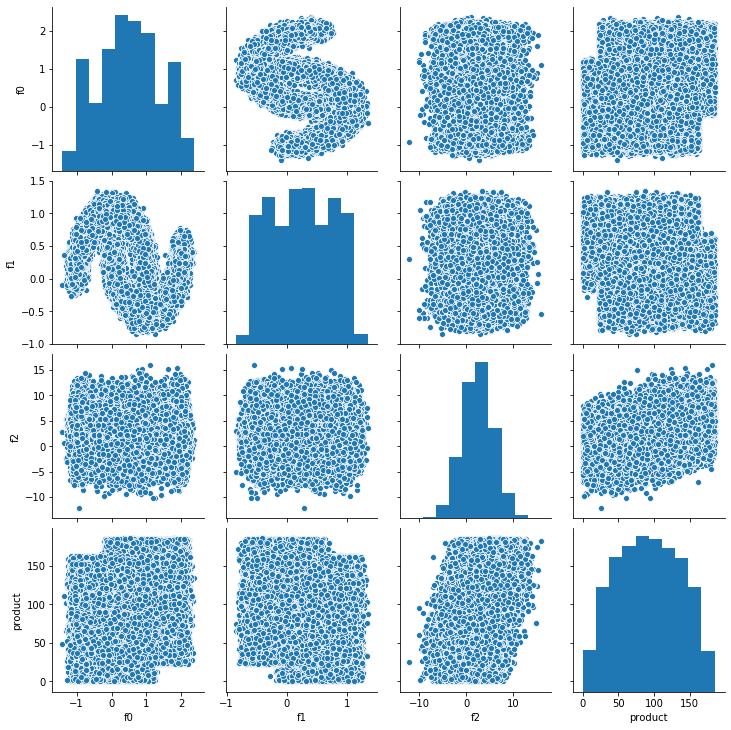

In [14]:
sns.pairplot(first_region)

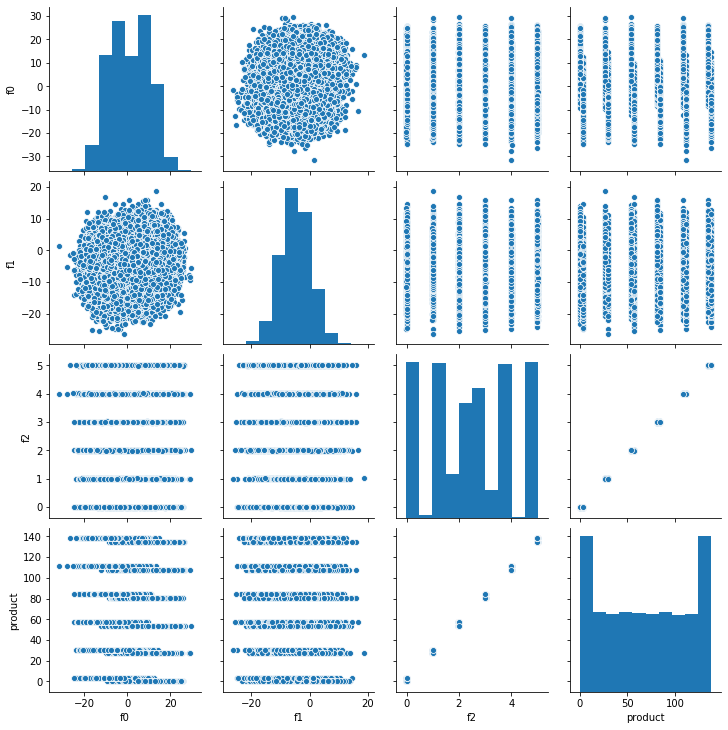

In [15]:
sns.pairplot(second_region)

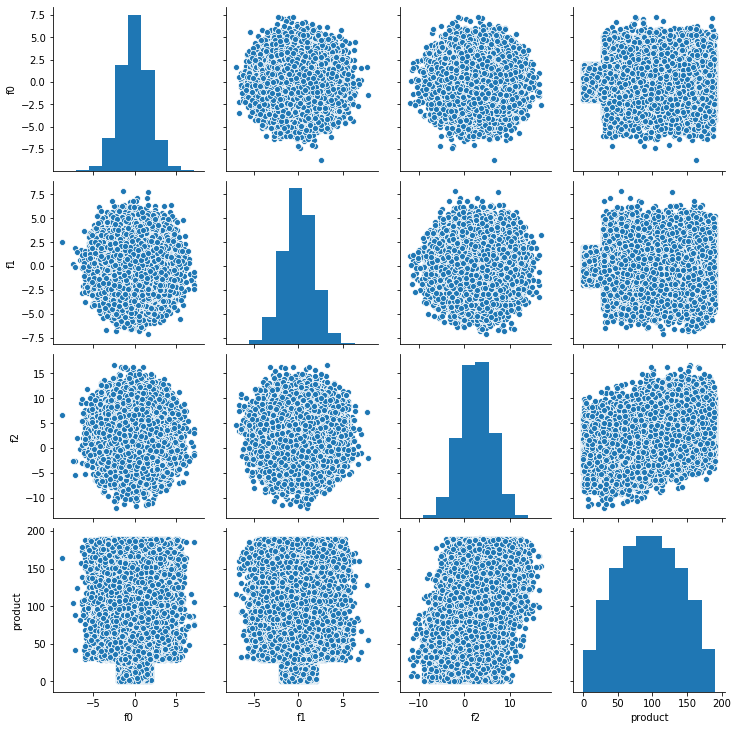

In [16]:
sns.pairplot(third_region)

**Вывод**: в данных по всем 3 регионам пропусков не обнаружено, а для хранения всех признаков используются значения c плавающей точкой. Так как коллизии в id для разных регионов мало, то спишем что это всё таки разные месторождения и эти ошибки возникают из-за слишком малого значения выделенного для хэш-пространства, следовательно, id не несут никакой информационной нагрузки и их можно дропнуть. При анализе статистик для всех регионов видно, что ключевые признаки f0 и f1 для всех регионов сильно варьируются, что видно по mean и std, а распределение признака f2 для первого и третьего регионов почти одинаковые, а для распределение f2 для второго региона имеет близкое среднее и меньший разброс относительного mean. 
Между параметрами f0,f1,f2 не наблюдается какой-либо корреляциия. Распределение большинства параметров носит нормальный вид, кроме распределения на втором участке, на котором распределение носит равномерный характер для f2 и целевого признака. Для второго региона видна чёткая прямая корреляция между признаком f2 и целевым признаком

# 2. Обучение и проверка модели

In [17]:
#Объединим всё в один DataFrame
all_regions=pd.concat([first_region,second_region,third_region])
all_regions.reset_index(drop=True, inplace=True)

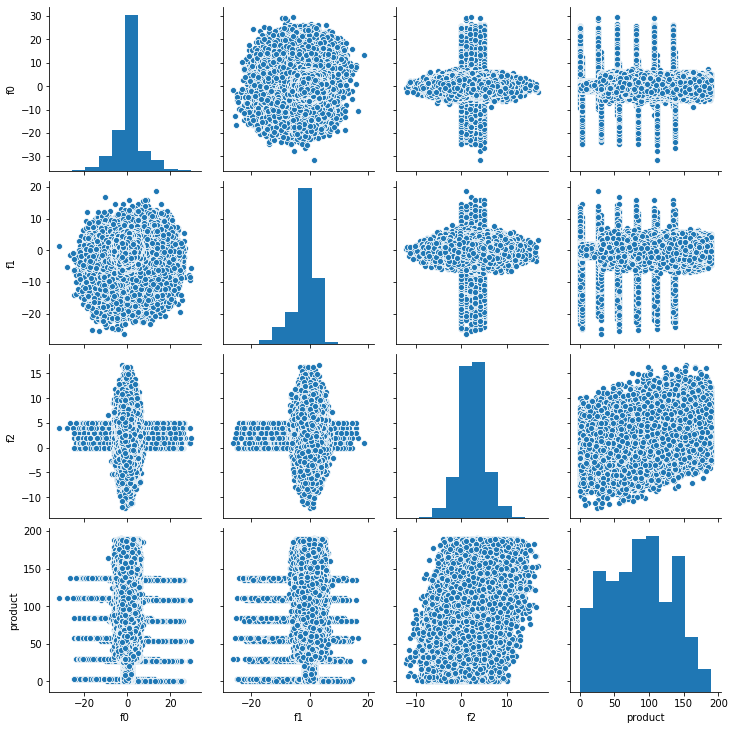

In [18]:
sns.pairplot(all_regions)

In [19]:
def model_education(train, valid, normalization):
    #Выделяем признаки и цели
    features_train=train.drop('product',axis=1)
    target_train=train['product']
    
    features_valid=valid.drop('product',axis=1)
    target_valid=valid['product']
    
    scaler=None
    #Нормируем при необходимости
    if normalization:
        columns=train.columns
        scaler=StandardScaler()
        features_train=pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
        features_valid=pd.DataFrame(scaler.transform(features_valid), columns=features_train.columns)
    
    #Строим модель и обучаем её
    model=LinearRegression()
    model.fit(features_train, target_train)
    
    predicted_values=model.predict(features_valid)
    
    score=mean_squared_error(target_valid, predicted_values)
    return scaler, model, np.sqrt(score), predicted_values, target_valid

In [20]:
def find_rmse(data, normalization):
    #проверка на то, что мы передали список DataFrame's 
    if isinstance(data,list):
        #Под возвращение
        scalers=[]
        models=[]
        scores=[]
        predictions=[]
        target_valids=[]
        #У нас на входе в функцию был список из 3 моделей
        for df in data:
            #Делим данные на тренировочные и валидационные
            train, valid=train_test_split(df, train_size=0.75,random_state=0, shuffle=True)
            #Обучаем модель тут
            scaler, model, score, prediction, target_valid=model_education(train, valid, normalization)
            #Сохраняем результаты
            scalers.append(scaler)
            models.append(model)
            scores.append(score)
            predictions.append(prediction)
            target_valids.append(target_valid)
        return scalers, models, scores, predictions, target_valids
    #В противном случае для обучения передана только 1 модель данных
    else:
        #Делим данные на тренировочные и валидационные
        train, valid=train_test_split(data, train_size=0.75,random_state=0, shuffle=True)
        #Обучаем модель 
        return model_education(train, valid, normalization)

In [21]:
#Статистика, в которой храним инфу
education_stat=pd.DataFrame(columns=['normalization', 
                                     'RMSE_1','RMSE_2','RMSE_3', 
                                     'model_1', 'model_2', 'model_3',
                                    'scaler_1', 'scaler_2', 'scaler_3'])

predictions_list=[]
target_valid_list=[]

for normalization in [False, True]:
    #На общем DataFrame
    scaler, model, score, prediction, target_valid=find_rmse(all_regions, normalization)
    education_stat.loc[len(education_stat)]=pd.Series([normalization, 
                                                       score,score,score,
                                                      model,model,model,
                                                      scaler,scaler,scaler],
                                                      index=education_stat.columns)
    predictions_list.append({1:prediction, 2:prediction, 3:prediction})
    target_valid_list.append({1:prediction, 2:prediction, 3:prediction})
    #На каждом отдельном
    scalers, models, scores, predictions, target_valids=find_rmse([first_region, second_region, third_region], normalization)
    
    row_number=len(education_stat)
    education_stat.loc[row_number]=pd.Series([normalization,
                                             None, None, None,
                                             None, None, None,
                                             None, None, None],
                                             index=education_stat.columns)
    
    predictions_list.append({})
    target_valid_list.append({})
    
    for i in range(len(scalers)):
        education_stat.loc[row_number,'RMSE_{}'.format(i+1)]=scores[i]
        education_stat.loc[row_number,'model_{}'.format(i+1)]=models[i]
        education_stat.loc[row_number,'scaler_{}'.format(i+1)]=scalers[i]
        predictions_list[len(predictions_list)-1][i+1]=predictions[i]
        target_valid_list[len(target_valid_list)-1][i+1]=target_valids[i]
    
education_stat

,normalization,RMSE_1,RMSE_2,RMSE_3,model_1,model_2,model_3,scaler_1,scaler_2,scaler_3
0,False,38.706659,38.706659,38.706659,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...",None,None,None
1,False,37.481009,0.887257,40.312907,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...",None,None,None
2,True,38.706659,38.706659,38.706659,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","StandardScaler(copy=True, with_mean=True, with...","StandardScaler(copy=True, with_mean=True, with...","StandardScaler(copy=True, with_mean=True, with..."
3,True,37.481009,0.887257,40.312907,"LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Tr...","StandardScaler(copy=True, with_mean=True, with...","StandardScaler(copy=True, with_mean=True, with...","StandardScaler(copy=True, with_mean=True, with..."


In [22]:
#Тут храним прогнозы и факты
predict=predictions_list[1]
actual=target_valid_list[1]
rmse=education_stat.iloc[1,1:4]

Регион №1
Средний запас предсказанного сырья: 92.27 тыс. баррелей
RMSE: 37.48100896950594



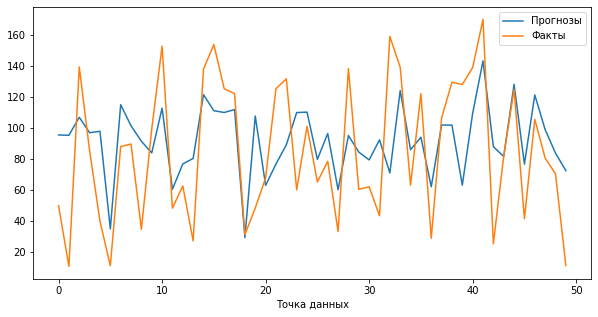

Регион №2
Средний запас предсказанного сырья: 69.15 тыс. баррелей
RMSE: 0.8872573052219325



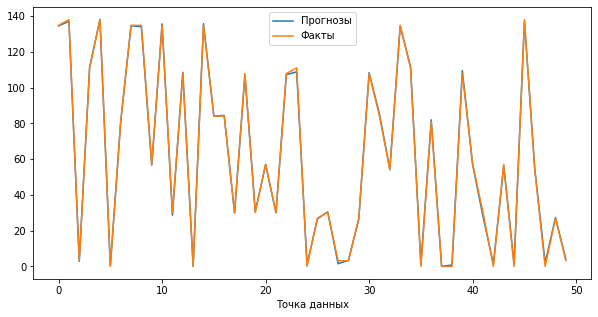

Регион №3
Средний запас предсказанного сырья: 94.71 тыс. баррелей
RMSE: 40.31290686044374



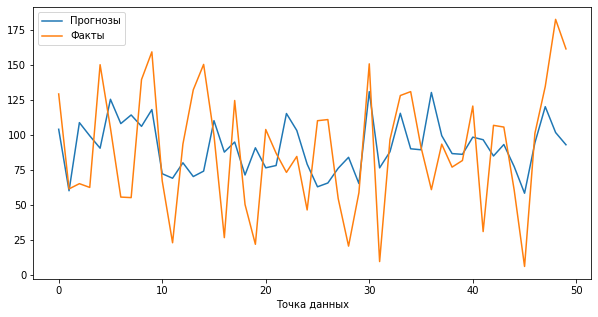

In [23]:
for number in predict.keys():
    print("Регион №{}".format(number))
    print("Средний запас предсказанного сырья: {:.2f} тыс. баррелей".format(predict[number].mean()))
    print("RMSE:", rmse[number-1], end='\n\n')
    
    lenth=50
    
    plt.figure(figsize=(10,5))
    plt.plot(predict[number][:lenth],label='Прогнозы')
    plt.plot(list(actual[number][:lenth]),label='Факты')
    plt.legend()
    plt.xlabel('Точка данных')
    plt.show()

**Вывод**: обучение осуществляется двумя метода: в первом случае мы строим 3 модели для каждой из областей, во втором мы строим одну модель. Так же для поиска наилучшего набора весов мы будем подавать на вход модели отнормированные и не нормированные признаки. Как видно из результатов, нормировка признаков не даёт никакого результата, следовательно нормировка значений ненужна. Аналия значения RMSE, видно, что максимальное RMSE при обучении 3 моделей ниже, чем RMSE для одной общей модели, следовательно, для расчётов использовались модели без нормировки. Наиболее точные прогнозы получаются для 2 региона, где RMSE почте на 200% меньше, чем в других.

# 3. Подготовка к расчёту прибыли

In [24]:
#Константы под ключевые значения
budget=10_000_000_000 #Бюджет на разработку скважин в одном регионе
research_amount=500   #Количество точек при разведке региона
best_amount=200       #Количество лучших точек для расчёта прибыли
revenue_per_thousand_barrel=450_000 #Доход с 1000 барелей
max_risk=0.025 #
cost_hole=budget/best_amount #Стоимость разработки одной скважины

In [25]:
#Достаточный объём сырья для безубыточной разработки новой скважины
break_even_volume=budget/revenue_per_thousand_barrel/best_amount
print('Достаточный объём сырья в скважине: {:.6f} тыс. баррелей'.format(break_even_volume))

Достаточный объём сырья в скважине: 111.111111 тыс. баррелей


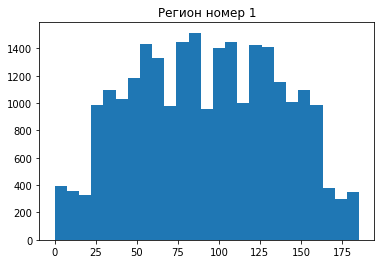

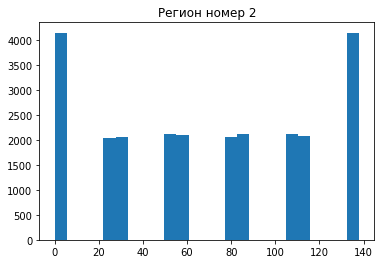

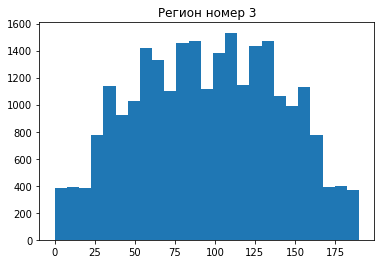

In [26]:
for i in actual:
    plt.title('Регион номер {}'.format(i))
    plt.hist(actual[i], bins=25)
    plt.show()

**Вывод**: исходя из того, что средний прогнозируемый объём скважен для кажогоиз регионов соответственно равен 92.27, 69.15, 94.71 тыс. барреей, а безубыточный объём начинается с  111 тыс. баррелей, то брать брать случайные скважины нельзя, так так есть риск не получить чистую прибыль больше 0

# 4. Расчёт прибыли и рисков 

In [27]:
#Функция для расчёта прибыли
#Чистая прибыль
def calculate_net_profit(actual_sample, predicted_sample, best_amount):
    #Сортируем прогнозы
    predicted_sorted=predicted_sample.sort_values(ascending=False)
    #Проссумируем наши фактические значения объёма и найдём выручку с региона
    revenue=actual_sample.loc[predicted_sorted.index][:best_amount].sum()*revenue_per_thousand_barrel
    #Валовая прибыль=оборот-себестоимость (стоимость скважины)
    gross_profit=revenue-cost_hole*best_amount
    #Чистая прибыль=Валовая прибыль - 20%*Валовая прибыль
    return 0.8*gross_profit

state = np.random.RandomState(12345)
bootstrap=1000

for region in predict:
    net_profit_list=[]
    #Объединим наши данные, чтобы удобнее было работать
    dataset=pd.DataFrame({'Прогнозы':predict[region],'Факты': actual[region]})

    for i in range(bootstrap):
        #Выбираем 500 значений без разрешения повторного выбора
        predicted_sample=dataset['Прогнозы'].sample(n=research_amount,
                                                    replace=False,
                                                   random_state=state)
        actual_sample=dataset.loc[predicted_sample.index,'Факты']
        net_profit_list.append(calculate_net_profit(actual_sample, predicted_sample, best_amount))
    
    net_profit_series=pd.Series(net_profit_list)
    
    loss_probability=len(net_profit_series[net_profit_series<0])/len(net_profit_series)
    
    print("Средняя прибыль для {} региона: {:.0f}".format(region,net_profit_series.mean() ))
    print('2.5%-квантиль: {:.0f}'.format(net_profit_series.quantile(0.025)))
    print('97.5%-квантиль: {:.0f}'.format(net_profit_series.quantile(0.975)))
    print('Вероятность убытков: {:%}'.format(loss_probability))
    
    print('='*20)
    

Средняя прибыль для 1 региона: 358055049
2.5%-квантиль: -31792952
97.5%-квантиль: 774942670
Вероятность убытков: 3.400000%
Средняя прибыль для 2 региона: 379000430
2.5%-квантиль: 69201770
97.5%-квантиль: 706497529
Вероятность убытков: 1.000000%
Средняя прибыль для 3 региона: 316363374
2.5%-квантиль: -84967089
97.5%-квантиль: 704420871
Вероятность убытков: 6.600000%


**Вывод**: чистая прибыль примерно от 316 до 379. Думаю акционеры одобрят раскопки. Но исходя из условия задачи, что вероятнсоть убытков не должна быть больше 2.5% единственный регион, подходящий под проект, является второй, который показал как минимальное RMSE на этапе обучения модели, так и наилучший доверительный интервал распределения прибыли, полученное с помощью методики Bootstrap(нижнее значение интервала положительное). К тому же данный регион показывает максимальное значение средней прибыли

# Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован